# Softmax Regression from Scratch


In [1]:
%matplotlib inline
import d2l
from mxnet import autograd, nd

We use the Fashion-MNIST data set with batch size 256.

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## Initialize Model Parameters

Since each example is an image with $28 \times 28$ pixels we can store it as a $784$ dimensional vector. Moreover, since we have 10 categories, the single layer network has an output dimension of 10. 

In [3]:
num_inputs = 784
num_outputs = 10

W = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b = nd.zeros(num_outputs)

As before, we have to attach a gradient to the model parameters.

In [4]:
W.attach_grad()
b.attach_grad()

## The Softmax

We can now define the softmax function. For that we first exponentiate each term using `exp` and then sum each row to get the normalization constant. Last we divide each row by its normalization constant and return the result.

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(X_{ij})}{\sum_k \exp(X_{ik})}
$$

In [5]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition  # The broadcast mechanism is applied here.

In [6]:
X = nd.random.normal(shape=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis=1)

(
 [[0.6264712  0.126293   0.01826552 0.10885343 0.12011679]
  [0.25569436 0.2917251  0.0754655  0.3024068  0.07470828]]
 <NDArray 2x5 @cpu(0)>, 
 [0.99999994 1.        ]
 <NDArray 2 @cpu(0)>)

## The Model

In [7]:
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b)

## The Loss Function

In [8]:
def cross_entropy(y_hat, y):
    return - nd.pick(y_hat, y).log()

## Classification Accuracy

Given a class of predicted probability distributions `y_hat`, we use the one with the highest predicted probability as the output category. 

In [9]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size
    return acc_sum / n

Because we initialized the `net` model with random weights, the accuracy of this model should be close to random guessing, i.e. 0.1 for 10 classes.

In [10]:
evaluate_accuracy(test_iter, net)

0.0856

## Model Training

In [14]:
def train(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)  # This will be illustrated in the next section.
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

In [15]:
num_epochs, lr = 5, 0.1
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs,
          batch_size, [W, b], lr)

epoch 1, loss 0.4782, train acc 0.838, test acc 0.842
epoch 2, loss 0.4695, train acc 0.841, test acc 0.843
epoch 3, loss 0.4620, train acc 0.842, test acc 0.845
epoch 4, loss 0.4563, train acc 0.844, test acc 0.845
epoch 5, loss 0.4516, train acc 0.846, test acc 0.847


## Prediction

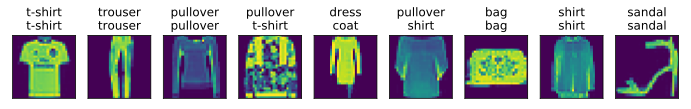

In [12]:
for X, y in test_iter:
    break

true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [truelabel + '\n' + predlabel for truelabel, predlabel in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])